In [139]:
"""
🧠 Brain CT Classification – Model Training and Grad-CAM++ Visualization

This script is for classifying Brain CT images into:
- Aneurysm
- Cancer
- Tumor

It uses TensorFlow with tf.data pipelines, pretrained models from keras.applications, and Grad-CAM++ 
for visualizing where the model is focusing.

Steps:
- Load and preprocess images using tf.data
- Build and train a CNN using pretrained models
- Visualize model attention with Grad-CAM++
"""

# === Imports ===
import os                        # For file paths
import numpy as np              # For array operations
import matplotlib.pyplot as plt # For image and heatmap display
from PIL import Image           # For optional image loading
from glob import glob           # For reading file paths
import pandas as pd             # Optional (e.g., for tracking metadata)
import warnings                 # Suppress unwanted warnings
warnings.filterwarnings('ignore')

In [140]:
# Set dataset path where images are stored by class folders
base_dir = "/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/train"

# List the class folders (aneurysm, cancer, tumor)
main_classes = os.listdir(base_dir)

# Show class names found
print(main_classes)

['aneurysm', 'cancer', 'tumor']


In [141]:
# Collect image info: class label and file path
data = []

for cls in main_classes:
    class_folder = os.path.join(base_dir, cls)
    if os.path.isdir(class_folder):
        # Get all images in the class folder
        image_files = glob(os.path.join(class_folder, '*.*'))  # jpg, png, etc.

        # Store class name and path for each image
        for img_path in image_files:
            data.append({
                'class': cls,
                'image_path': img_path
            })

# Convert to DataFrame for easy viewing or manipulation
df = pd.DataFrame(data)

# Preview dataset sample
df.head()

,class,image_path
0,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
1,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
2,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
3,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
4,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...


In [143]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Input, Model

In [144]:
# Define simple augmentation with random flip, rotation, zoom
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Process function with augmentation applied
def process_path_aug(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    img = data_augmentation(img)  # Apply augmentation here
    return img, label

# Process function without augmentation (for validation/test)
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

In [145]:
def get_filepaths_and_labels(data_dir):
    class_names = sorted(os.listdir(data_dir))
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    file_paths = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image))
            labels.append(class_indices[class_name])

    return tf.convert_to_tensor(file_paths), tf.convert_to_tensor(labels)

def prepare_dataset(file_paths, labels, aug=False):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if aug:
        ds = ds.map(process_path_aug, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

In [146]:
train_dir = '/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/train'
test_dir = '/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/train'

In [147]:
from sklearn.model_selection import train_test_split

# Load data paths and labels
file_paths, labels = get_filepaths_and_labels(train_dir)
test_paths, test_labels = get_filepaths_and_labels(test_dir)

# Split with sklearn
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths.numpy(), labels.numpy(), test_size=0.2, stratify=labels.numpy(), random_state=42)

# Convert back to tensor
train_paths, val_paths = tf.convert_to_tensor(train_paths), tf.convert_to_tensor(val_paths)
train_labels, val_labels = tf.convert_to_tensor(train_labels), tf.convert_to_tensor(val_labels)

In [148]:
# Prepare datasets
train_ds = prepare_dataset(train_paths, train_labels, aug=False).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = prepare_dataset(val_paths, val_labels).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = prepare_dataset(test_paths, test_labels).batch(32).prefetch(tf.data.AUTOTUNE)

In [158]:
from tensorflow.keras.applications import InceptionResNetV2

# Load pretrained EfficientNetV2B3 without the classification head
base_model = InceptionResNetV2(
    include_top=False,         # Remove original classifier
    weights='imagenet',        # Use ImageNet pretrained weights
    input_shape=(224, 224, 3), # Input size must match your data
    pooling='avg'              # Global average pooling for feature vector
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [159]:
# Enable training for the entire model first
base_model.trainable = False

# Freeze all layers except the last 5 for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [160]:
# inputs = Input(shape=(224, 224, 3))
# x = base_model(inputs, training=False)  # pass inputs through base_model.
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.3)(x)
outputs = Dense(len(main_classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Low LR for fine-tuning
    loss='sparse_categorical_crossentropy',                 # Suitable loss for integer labels
    metrics=['accuracy']                                     # Track accuracy metric
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model_best.h5", save_best_only=True),  # Save best model
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)    # Stop early if no improvement
    ]
)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 744ms/step - accuracy: 0.5081 - loss: 1.0391 - val_accuracy: 0.8552 - val_loss: 0.5607
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.8593 - loss: 0.5338 - val_accuracy: 0.9189 - val_loss: 0.3524
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9434 - loss: 0.3481 - val_accuracy: 0.9633 - val_loss: 0.2363
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.9607 - loss: 0.2404 - val_accuracy: 0.9730 - val_loss: 0.1666
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.9659 - loss: 0.1965 - val_accuracy: 0.9788 - val_loss: 0.1276
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.9751 - loss: 0.1687 - val_accuracy: 0.9865 - val_loss: 0.0992
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.9845 - loss: 0.1146 - val_accuracy: 0.9865 - val_loss: 0.0826
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.9872 - loss: 0.1000 - val_accu

In [161]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.9932 - loss: 0.0216
Test Accuracy: 0.99


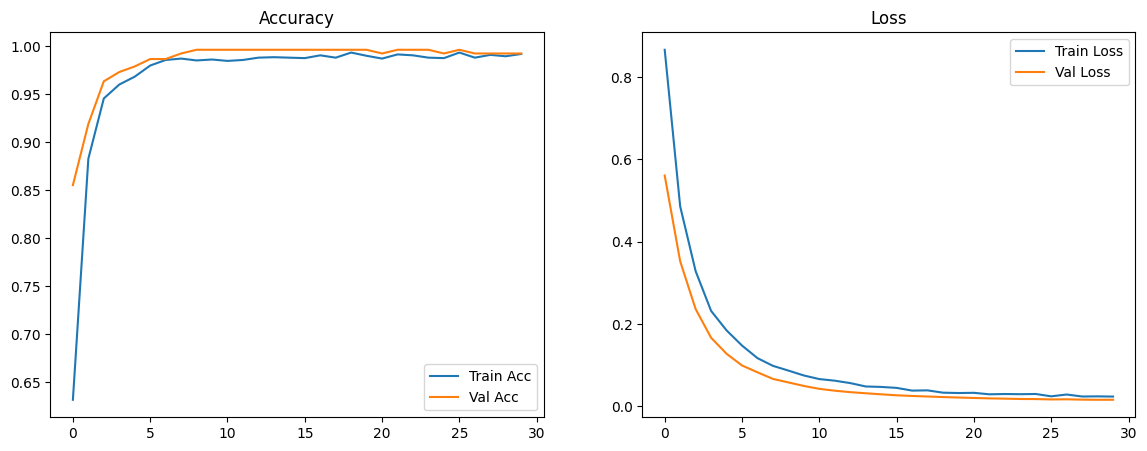

In [162]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
!pip install tf_keras_vis

In [165]:
model.get_layer('conv_7b_ac')

<Activation name=conv_7b_ac, built=True>

In [166]:
import cv2
replace2linear = ReplaceToLinear()

In [175]:
import matplotlib.pyplot as plt

def plot_cam_comparison(original, gradcam_heatmap, gradcampp_heatmap, scorecam_heatmap):
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(original)
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    axs[1].imshow(gradcam_heatmap)
    axs[1].axis('off')
    axs[1].set_title("Grad-CAM")

    axs[2].imshow(gradcampp_heatmap)
    axs[2].axis('off')
    axs[2].set_title("Grad-CAM++")

    axs[3].imshow(scorecam_heatmap)
    axs[3].axis('off')
    axs[3].set_title("Score-CAM")

    plt.tight_layout()
    plt.show()

In [176]:
def overlay_heatmap(img, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * cam[0])  # cam is (1, H, W), take [0]
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = heatmap * alpha + img[0].astype(np.uint8)
    return superimposed_img

In [177]:
from tensorflow.keras.preprocessing import image
img_path = '/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/test/aneurysm/3_11.jpg'
sample_image,_ = process_path(img_path, 0)
sample_image = tf.expand_dims(sample_image, axis=0)

import numpy as np

# Convert Tensor to NumPy before using .max()
img_array = sample_image[0].numpy()  # Convert to NumPy

if img_array.max() <= 1.0:
    display_img = (img_array * 255).astype(np.uint8)
else:
    display_img = img_array.astype(np.uint8)

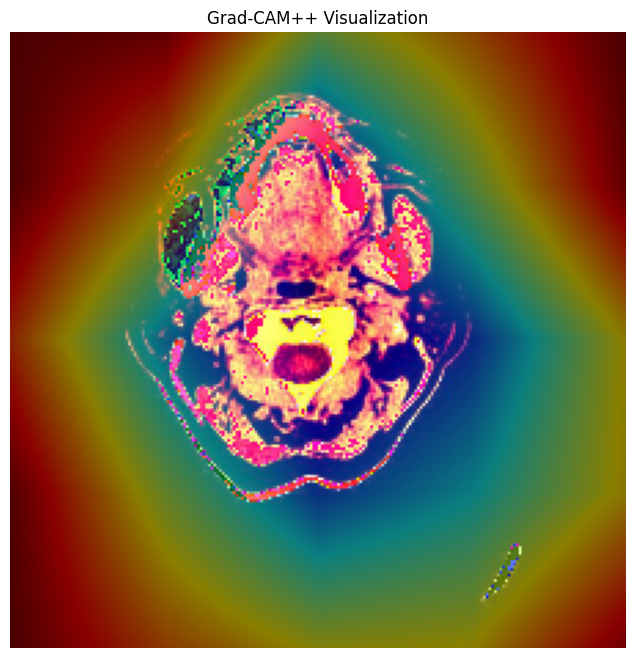

In [178]:
gradcam = GradcamPlusPlus(model, model_modifier=replace2linear)
score = CategoricalScore([0])  # Replace 0 with your target class index
cam_gcp = gradcam(score, seed_input=sample_image, penultimate_layer='conv_7b_ac', training=False)

heatmap_gcp = overlay_heatmap(np.expand_dims(display_img, 0), cam)

plt.figure(figsize=(8, 8))
plt.imshow(result.astype(np.uint8))
plt.axis('off')
plt.title('Grad-CAM++ Visualization')
plt.show()

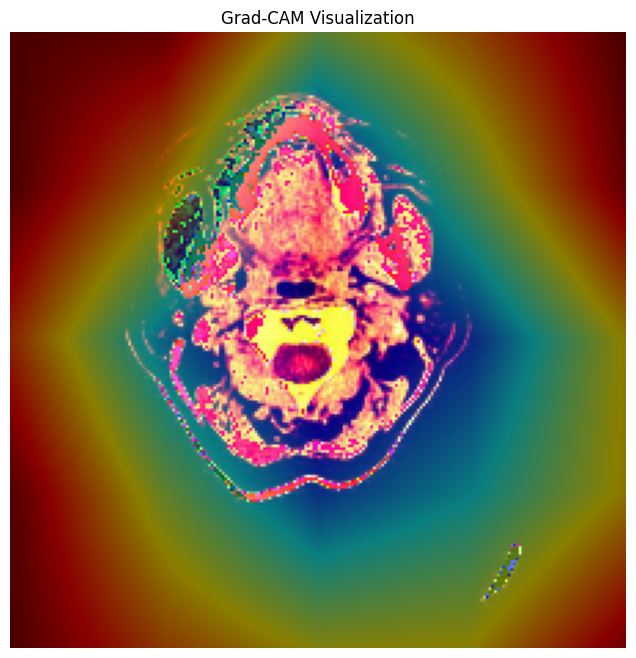

In [179]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model, model_modifier=replace2linear)
cam_gc = gradcam(score, seed_input=sample_image, penultimate_layer='conv_7b_ac', training=False)

heatmap_gc = overlay_heatmap(np.expand_dims(display_img, 0), cam)

plt.figure(figsize=(8, 8))
plt.imshow(result.astype(np.uint8))
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step


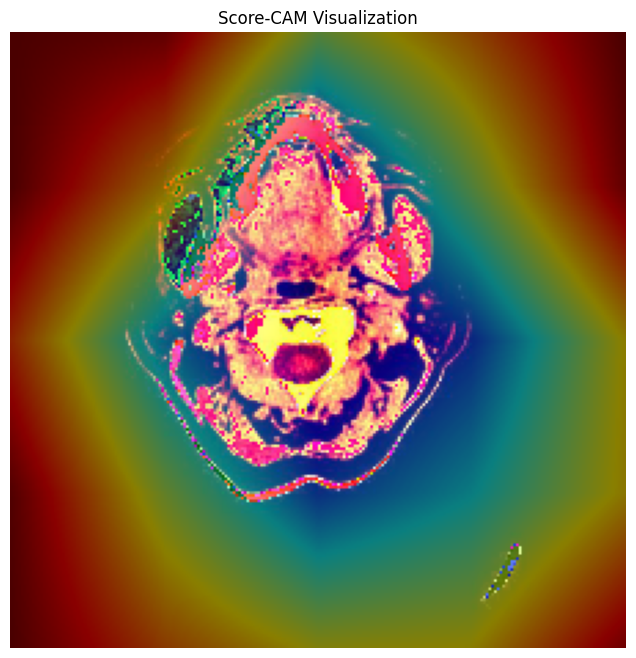

In [180]:
from tf_keras_vis.scorecam import Scorecam

scorecam = Scorecam(model, model_modifier=replace2linear)
cam_sc = scorecam(score, seed_input=sample_image, penultimate_layer='conv_7b_ac', training=False)

heatmap_sc = overlay_heatmap(np.expand_dims(display_img, 0), cam)

plt.figure(figsize=(8, 8))
plt.imshow(result.astype(np.uint8))
plt.axis('off')
plt.title('Score-CAM Visualization')
plt.show()


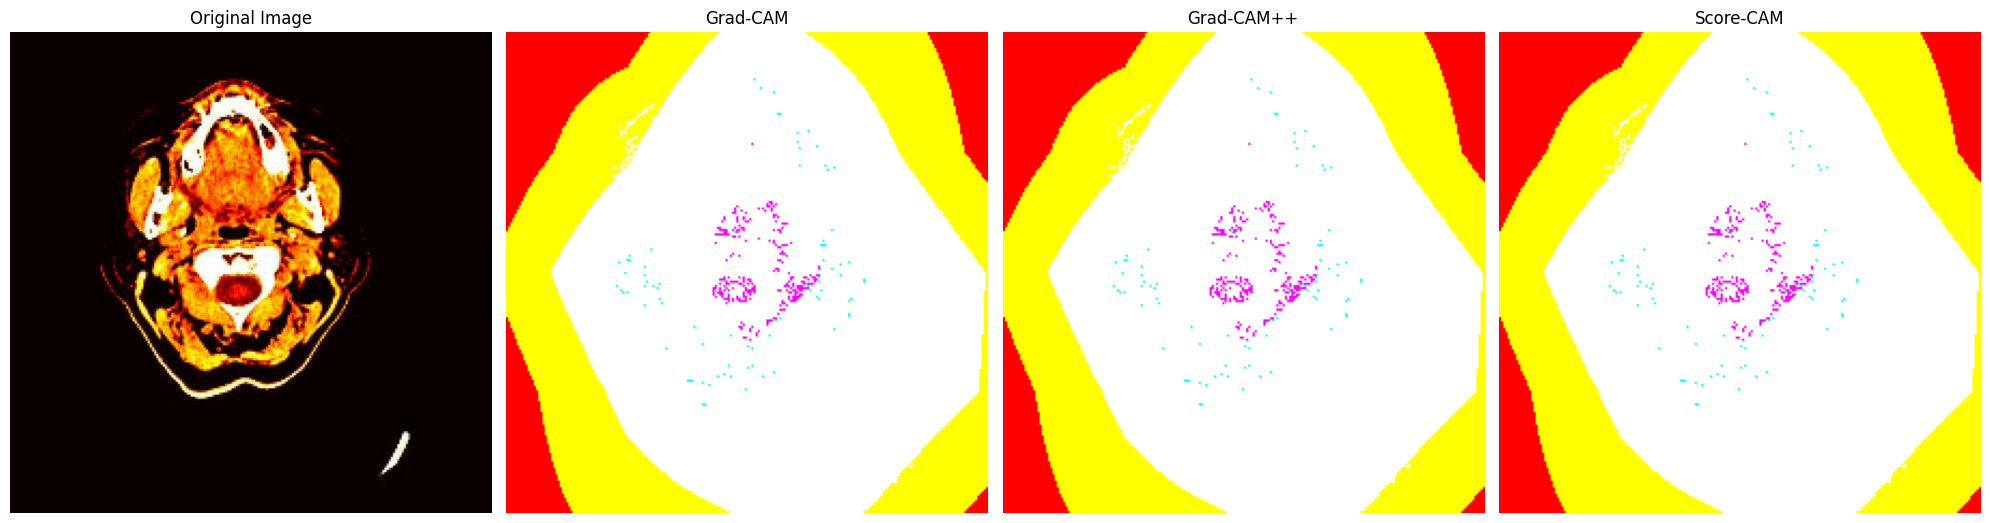

In [181]:
plot_cam_comparison(display_img, heatmap_gc, heatmap_gcp, heatmap_sc)

In [183]:
import matplotlib.pyplot as plt

def plot_cam_comparison(original, gradcam_heatmap, gradcampp_heatmap, scorecam_heatmap):
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(original)
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    axs[1].imshow(gradcam_heatmap.astype(np.uint8))
    axs[1].axis('off')
    axs[1].set_title("Grad-CAM")

    axs[2].imshow(gradcampp_heatmap.astype(np.uint8))
    axs[2].axis('off')
    axs[2].set_title("Grad-CAM++")

    axs[3].imshow(scorecam_heatmap.astype(np.uint8))
    axs[3].axis('off')
    axs[3].set_title("Score-CAM")

    plt.tight_layout()
    plt.show()

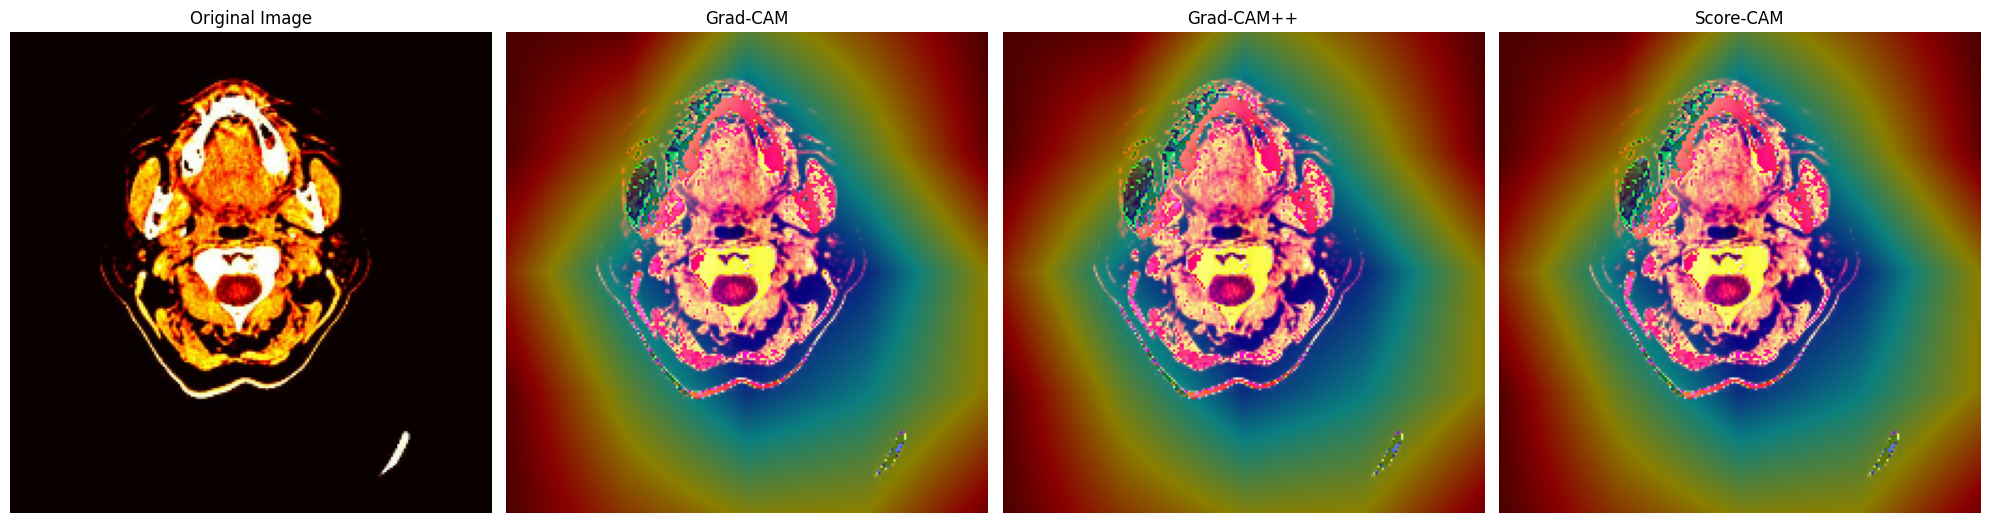

In [184]:
plot_cam_comparison(display_img, heatmap_gc, heatmap_gcp, heatmap_sc)

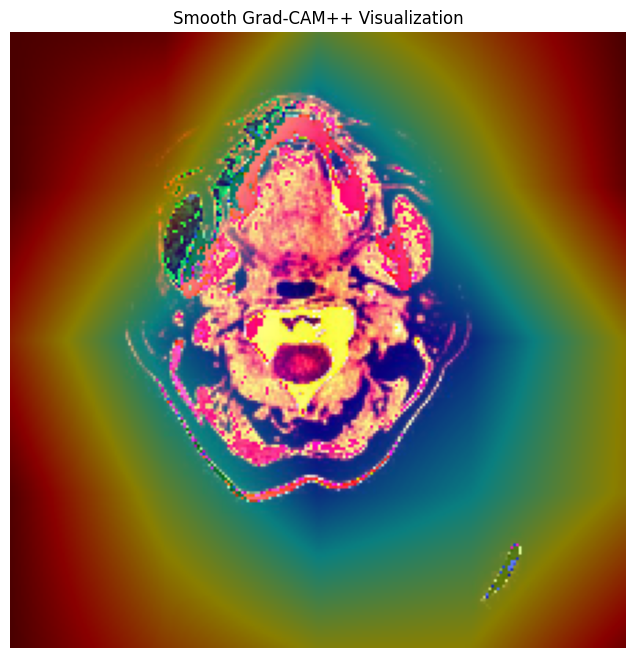

In [172]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcampp = GradcamPlusPlus(model, model_modifier=replace2linear)
cam = gradcampp(score, seed_input=sample_image, penultimate_layer='conv_7b_ac', training=True)

result = overlay_heatmap(np.expand_dims(display_img, 0), cam)

plt.figure(figsize=(8, 8))
plt.imshow(result.astype(np.uint8))
plt.axis('off')
plt.title('Smooth Grad-CAM++ Visualization')
plt.show()
